# Исcледование игр.

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Нужно отработать принцип работы с данными.

В данном иследование я проверю данные на ошибки и исправлю их при необходимости, затем проведу статистические исследоваиния и выявлю характерные признаки поведения пользователей, в завершающей части проверю несколько гипотез о равенсве признаков. 

### Шаг 1. Загрузка данных и изучение общеё информации

In [84]:
# импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Импортируем pymystem3:
from pymystem3 import Mystem
from collections import Counter

pd.options.mode.chained_assignment = None

In [85]:
# чтение файла
data_games = pd.read_csv("/datasets/games.csv")

In [86]:
# получение первых 5 строк таблицы
data_games.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [87]:
# получение общей информации о данных в таблице
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


---

### Вывод:

Описание данных:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

В данных наблюдается несоответсвие типов данных в столбце User_Score, также наблюдаются пропуски данных.
Это может быть вызвано ошибками при внесение данных или ошибках при выгрузке.
Возможно данные рейтингов не были загружены в этом случае их можно пропустить и не запоолнять пропуски, чтобы не исказить картину.

---

### Шаг 2. Подготовка данных

In [88]:
# перечень названий столбцов таблицы
data_games.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [89]:
# переименование столбцов
data_games.set_axis(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'], axis='columns', inplace=True)

In [90]:
# перечень названий столбцов таблицы
data_games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [91]:
# замена типа данных в столбце с годом
data_games['year_of_release'] = data_games['year_of_release'].astype('Int64')

In [92]:
# суммарное количество пропусков
data_games.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [93]:
# пропроверка пропусков в ['name', 'genre']
data_games[['name', 'genre']].query("name.isna()")

,name,genre
659,NaN,NaN
14244,NaN,NaN


In [94]:
# удалим эти сторки так как их всего 2 и вариантов замены в название нет
data_games.dropna(subset=['name'], inplace = True)
data_games.isnull().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

In [95]:
# фуднкция для подсчета суммарных продаж
def total_sales (data_games):
    total_sale = 0
    na_sales = data_games['na_sales']
    eu_sales = data_games['eu_sales']
    jp_sales = data_games['jp_sales']
    other_sales = data_games['other_sales']
    total_sale = na_sales + eu_sales + jp_sales + other_sales
    return total_sale

# применим функцию для создания нового столбца
data_games['total_sales'] = data_games.apply(total_sales, axis=1)

In [96]:
data_games.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,total_sales
count,16444.000000,16713.000000,16713.000000,16713.000000,16713.000000,8137.000000,16713.000000
mean,2006.486256,0.263302,0.145045,0.077625,0.047343,68.967679,0.533315
std,5.875525,0.813565,0.503359,0.308871,0.186742,13.938165,1.548282
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,82.540000


In [97]:
# функция для определения года игры из названия   
def name(data_games):
    
    for i in range(1980, 2020):
        if str(i) in data_games:
            return int(i)

        
data_games['year_of_release'] = data_games['year_of_release'].fillna(0)
data_games['year_in_name'] = data_games['name'].apply(name)
data_games['year_of_release'] = data_games['year_of_release'].replace(0, data_games['year_in_name'])
data_games["year_of_release"] = data_games.groupby('platform')['year_of_release'].transform(lambda x: x.replace(0, x.mean()))
data_games.query("year_of_release == 0")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,year_in_name


In [98]:
# удалим оставшиеся пропуски в столбце 'year_of_release'
data_games.dropna(subset=['year_of_release'], inplace = True)

# замена типа данных в столбце с годом
data_games['year_of_release'] = data_games['year_of_release'].astype('Int64')

# проведя исследования в интернете TBD это не определенный рейтинг, то есть заменим данный на Nan
data_games['user_score'] = data_games['user_score'].replace('tbd', np.nan)

# замена типа данных
data_games["user_score"] = data_games["user_score"].astype('float64')


In [99]:
# проведем группировку рейтинга по жанру
data_games.groupby(['genre'])['rating'].first()

genre
Action          M
Adventure       M
Fighting        T
Misc            E
Platform        E
Puzzle          E
Racing          E
Role-Playing    T
Shooter         M
Simulation      E
Sports          E
Strategy        T
Name: rating, dtype: object

In [100]:
# функция для замены пропусказ в столбце 'rating' на основание группировки по жанрам
def rating(row):
    if row == 'Action':
            return 'M'
    if row == 'Adventure':
            return 'M'
    if row == 'Fighting':
            return 'T'
    if row == 'Misc':
            return 'E'
    if row == 'Platform':
            return 'E'
    if row == 'Puzzle':
            return 'E'
    if row == 'Racing':
            return 'E'
    if row == 'Role-Playing':
            return 'T'
    if row == 'Shooter':
            return 'M'
    if row == 'Simulation':
            return 'E'
    if row == 'Sports':
            return 'E'
    if row == 'Strategy':
            return 'T'

# применим функцию для ранее полученной таблицы           
data_games['rating'] = data_games['rating'].fillna(0)
data_games['rating_genre'] = data_games['genre'].apply(rating)
data_games['rating'] = data_games['rating'].replace(0, data_games['rating_genre'])


In [101]:
# проверка на пропуски
data_games.isnull().sum()

name                   0
platform               0
year_of_release        0
genre                  0
na_sales               0
eu_sales               0
jp_sales               0
other_sales            0
critic_score        8466
user_score          8988
rating                 0
total_sales            0
year_in_name       15613
rating_genre           0
dtype: int64

In [102]:
# получение суммарного количества дубликатов в таблице
data_games.duplicated().sum()

0

### Шаг 3. Исследовательский анализ данных

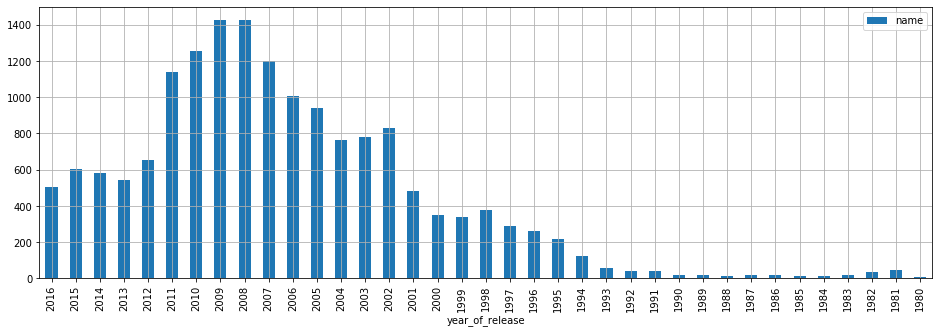

In [103]:
# сводная таблица с колличеством игр в разбивке по годам.
yers_pivot = (data_games
                   .pivot_table(index='year_of_release',
                                values='name', 
                                aggfunc='count'
                               )
                )
yers_pivot.sort_values(by='year_of_release', ascending=False).plot(grid=True, kind='bar', figsize=(16, 5))

Данные по годам не показательны. Продажи в 2015 и 2016 годах меньше чем в 2008.
Продажи игр сначала рости 

In [104]:
# сводная таблица с сумой продаж по платформам
platform_pivot = (data_games
                   .pivot_table(index='platform',
                                values='total_sales', 
                                aggfunc='sum'
                               )
                )
platform_pivot.sort_values(by='total_sales', ascending=False).head(5)

,total_sales
platform,
PS2,1247.28
X360,961.30
PS3,931.34
Wii,891.18
DS,802.79


In [105]:
# напишем функцию, которая строит гистограмму продаж для выбранной платформы.
def plot_year(data_games, platform):
    data_platform = data_games.query("platform == @platform")
    data_platform_pivot = (data_platform
                           .pivot_table(index='year_of_release', 
                                        values='total_sales', 
                                        aggfunc='sum'
                                       )
                           .plot(
                               grid=True,
                               kind='bar',
                               figsize=(8, 5)
                           )
                          )


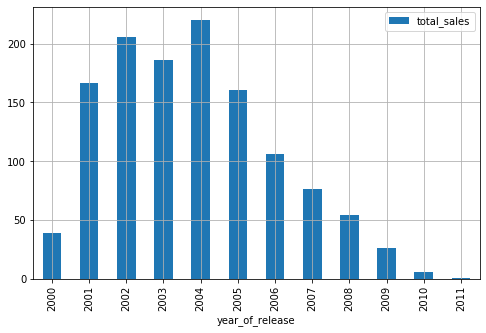

In [106]:
# гистограмма для PS2
plot_year(data_games, 'PS2')

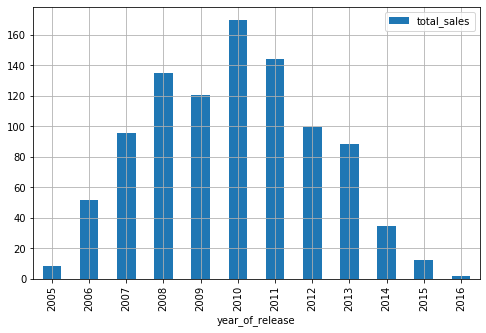

In [107]:
# гистограмма для X360
plot_year(data_games, 'X360')

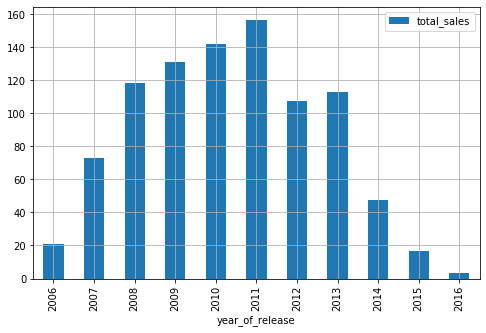

In [108]:
# гистограмма для PS3
plot_year(data_games, 'PS3')

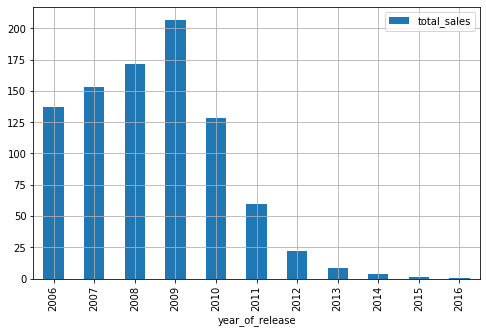

In [109]:
# гистограмма для Wii
plot_year(data_games, 'Wii')

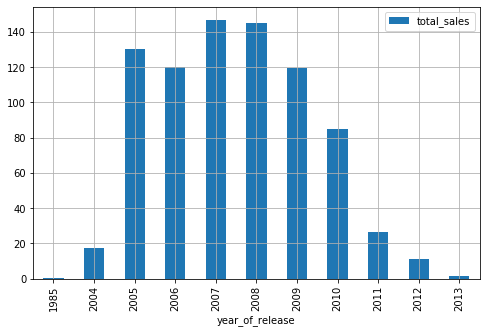

In [110]:
# гистограмма для DS
plot_year(data_games, 'DS')

Проверив ТОП 5 платформ по сумме продаж в разбивке по годам наблюдается рост популярности платформы в первые 5-6 лет и затем спад. Срок жизни платформы в среднем 10 лет.

Сделам срез данных с 2011 года.

In [111]:
# срез данных с 2011 года для дальнейшего анализа
actual_data_games = (data_games
                     .query("year_of_release >= 2011"
                           )
                    )
                     
# сводная таблица по платфомам
actual_data_games_pivot = (actual_data_games
                          .pivot_table(index='platform',
                                       values='total_sales', 
                                       aggfunc='sum'
                                 )
                          .sort_values(by='total_sales',
                                       ascending=False
                                      )
                         )
    
actual_data_games_pivot

,total_sales
platform,
PS3,445.57
X360,380.43
PS4,314.14
3DS,257.81
XOne,159.32
PC,98.03
Wii,95.02
WiiU,82.19
PSV,53.81


Наибольшие продажи наблюдаютя на платформе PS3 (445,57 млн. долл), далее идет X360 (380,43 млн. долл), затем PS4 (314,14 млн. долл).

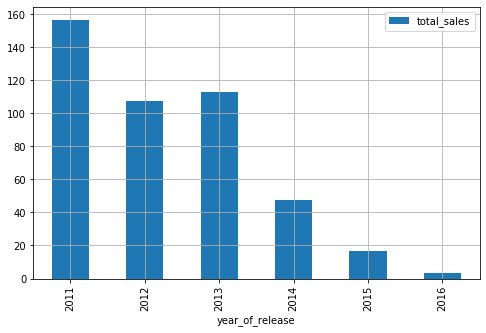

In [112]:
# гистограмма для PS3 c 2011 г.
plot_year(actual_data_games, 'PS3')

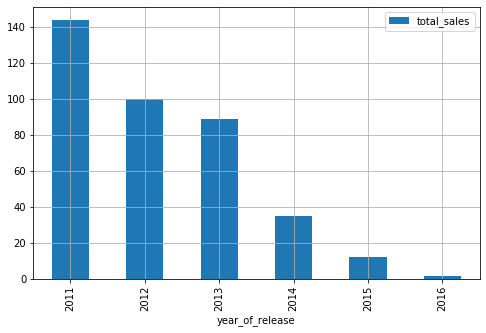

In [113]:
# гистограмма для X360 c 2011 г.
plot_year(actual_data_games, 'X360')

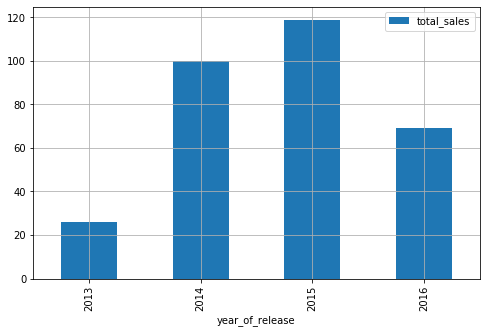

In [114]:
# гистограмма для PS4 c 2011 г.
plot_year(actual_data_games, 'PS4')

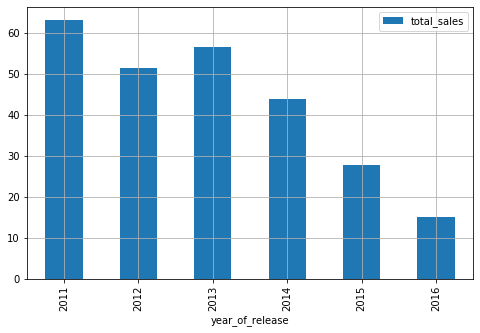

In [115]:
# гистограмма для 3DS c 2011 г.
plot_year(actual_data_games, '3DS')

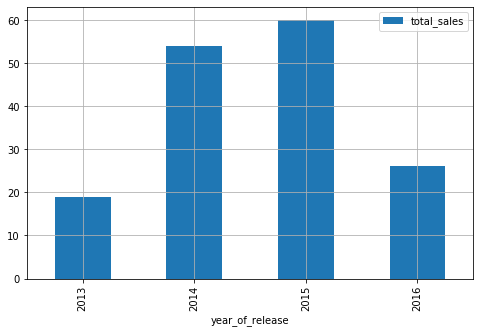

In [116]:
# гистограмма для XOne c 2011 г.
plot_year(actual_data_games, 'XOne')

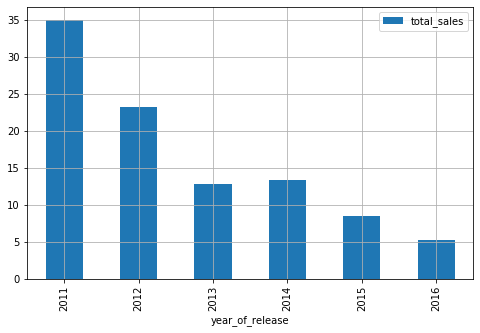

In [117]:
# гистограмма для PC c 2011 г.
plot_year(actual_data_games, 'PC')

На основание полученной таблицы и построив гистограммы по платформам можно сделать выводы, что за последние 6 лет наблюдается спад продаж на платформах PS3 X360 PC, то есть можно сделдать вывод, что пик популярности этих платформ прошёл.

Судя по данным наиболее перспективными платформами являются PS4 XOne продажи этих платформ растут, то есть у них есть перспектива развития.

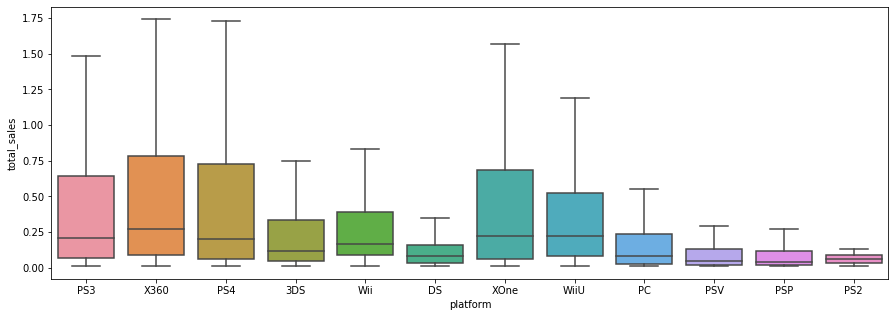

In [118]:
# график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. 
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 5), sharey=True)
sns.boxplot(x="platform",  y="total_sales",  data=actual_data_games, showfliers = False)

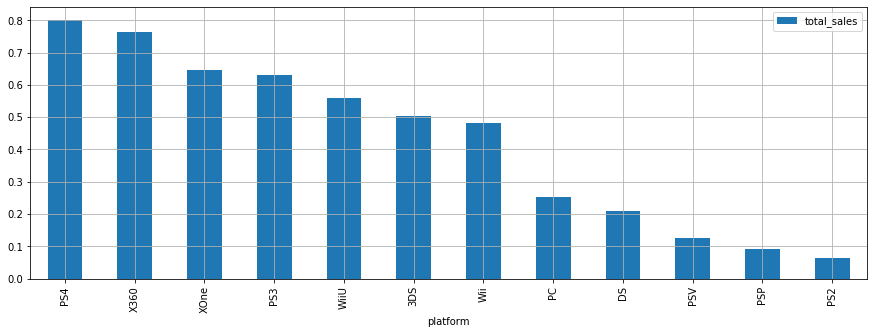

In [119]:
# сводная таблица с усредненными данными по продажам
actual_games_pivot_mean = (actual_data_games
                          .pivot_table(index='platform',
                                       values='total_sales', 
                                       aggfunc='mean'
                                 )
                          .sort_values(by='total_sales',
                                       ascending=False
                                      )
                           .plot(grid=True, kind='bar', figsize=(15, 5))
                         )
actual_games_pivot_mean

Построив "ящик с усами" и гистограмму с по среднем продажам, можно выделить наиболее популярные платформы: PS4, X360, XOne и PS4. 

##### Анализ зависимости продаж от оценок критиков и пользователей

In [120]:
# рассчитаем кореляцию 
actual_data_games[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.329826,0.031318
critic_score,0.329826,1.000000,0.533905
user_score,0.031318,0.533905,1.000000


Наибольшая корреляция продаж с оценками критиков 0,3

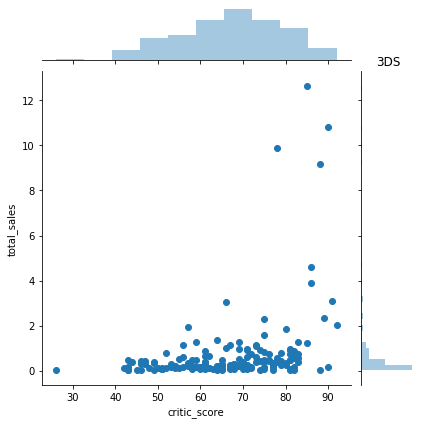

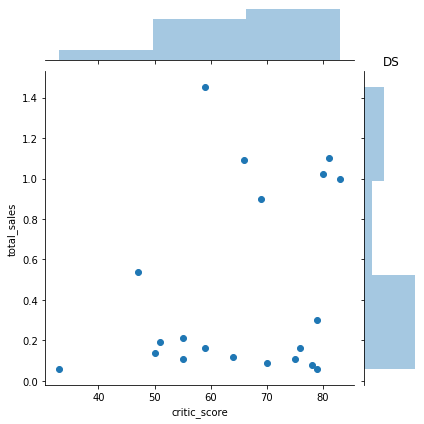

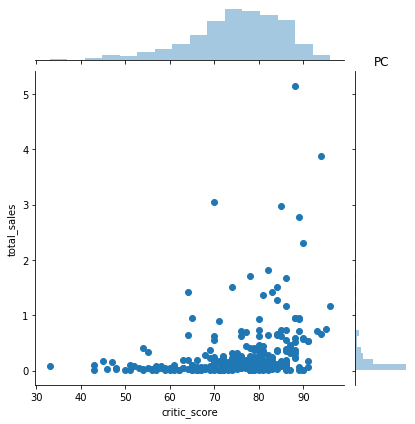

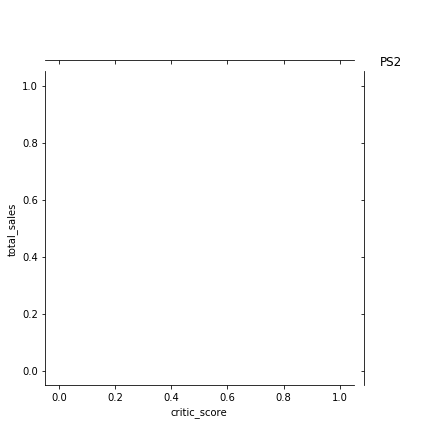

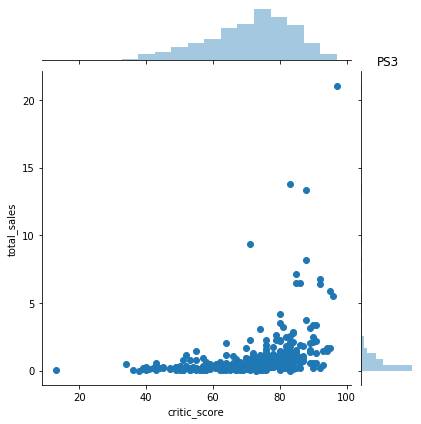

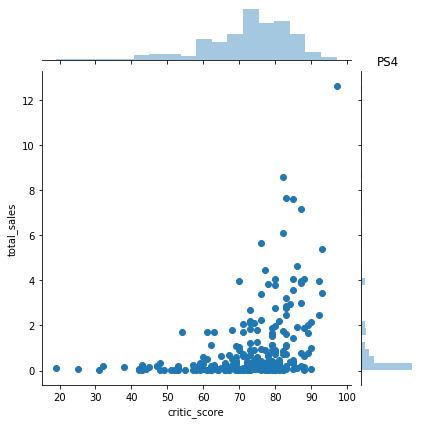

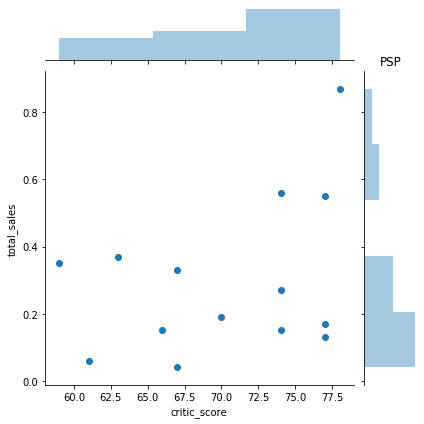

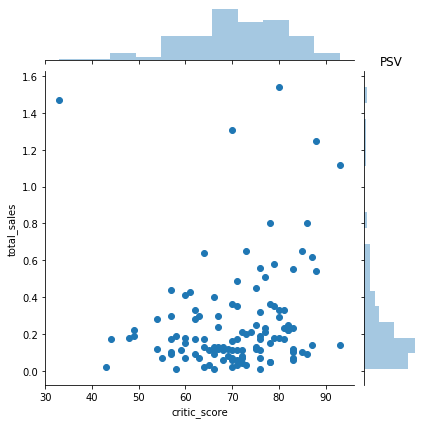

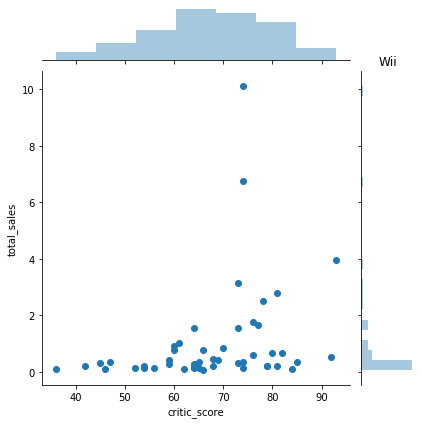

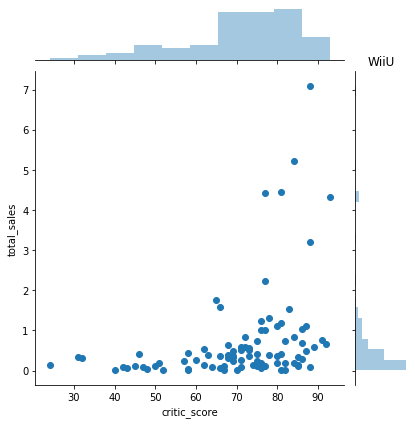

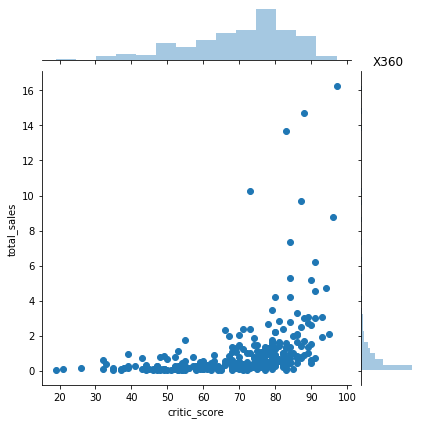

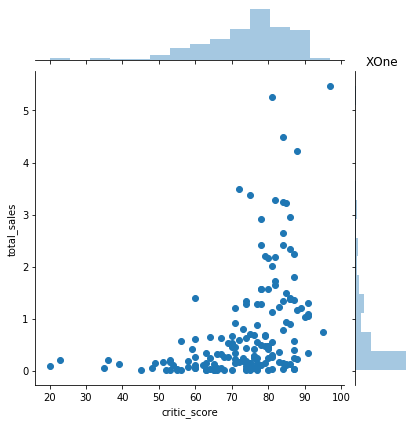

In [121]:
for name, group_data in actual_data_games.groupby('platform'):
    sns.jointplot(x='critic_score', y='total_sales', data = group_data)
    plt.title(name)
plt.show()

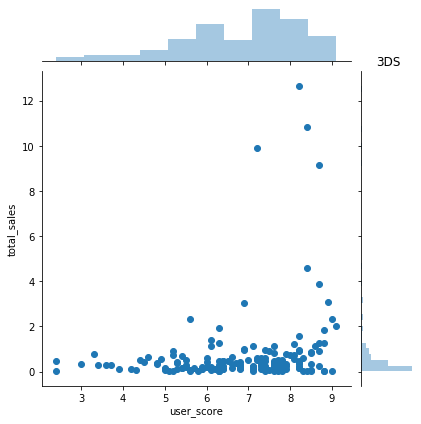

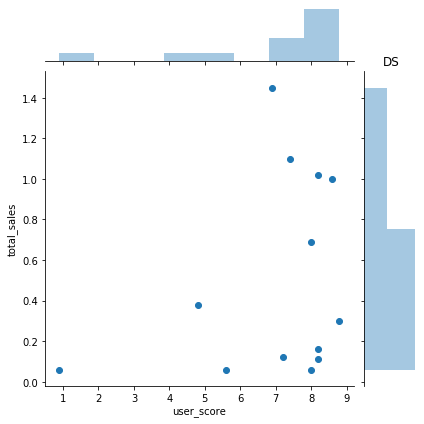

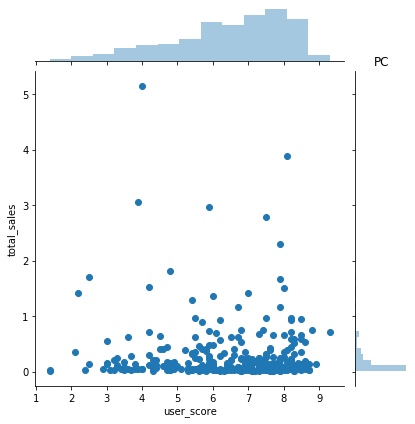

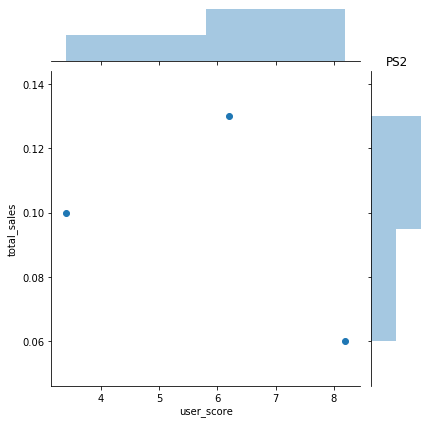

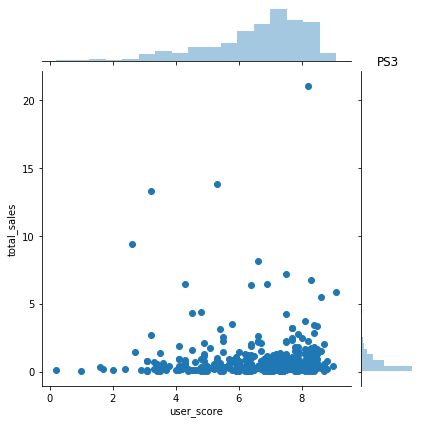

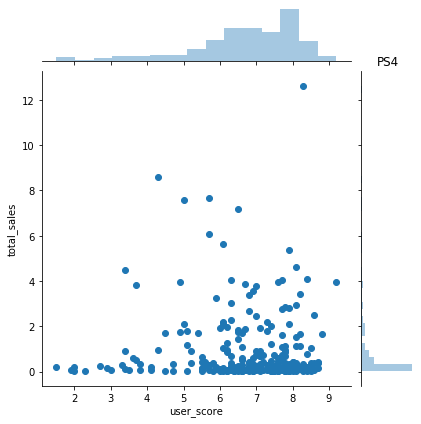

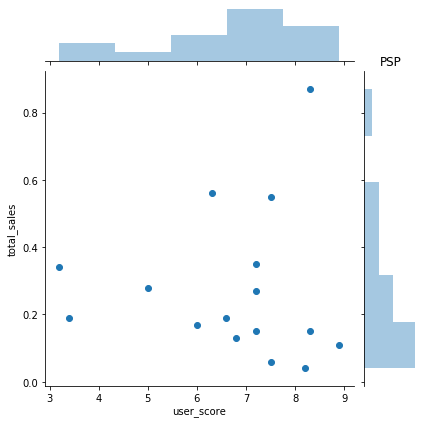

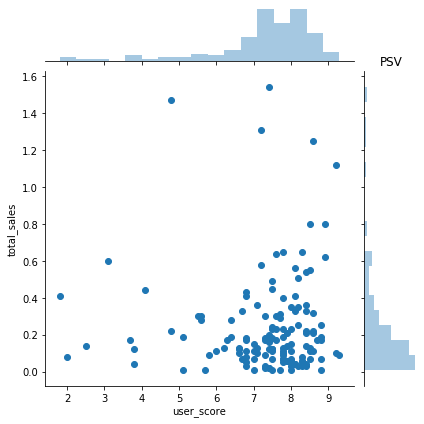

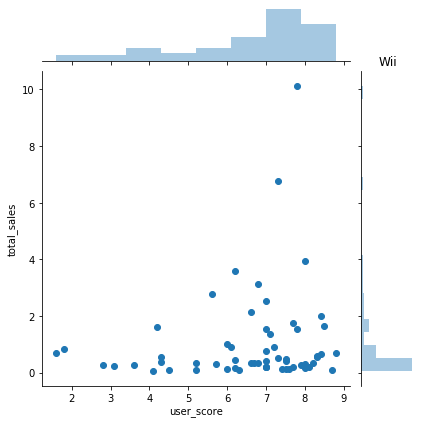

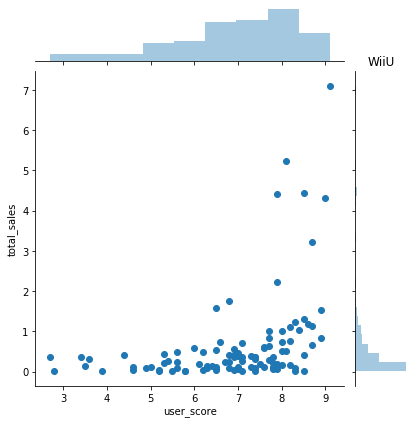

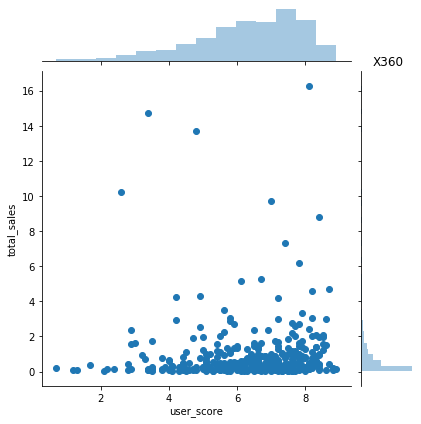

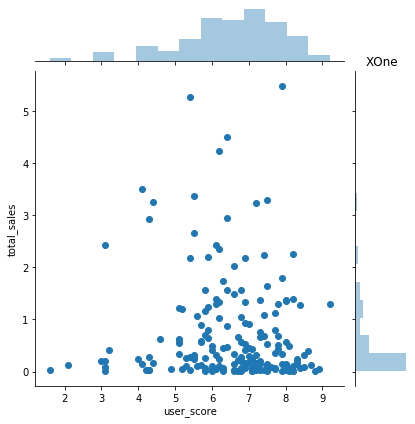

In [122]:
for name, group_data in actual_data_games.groupby('platform'):
    sns.jointplot(x='user_score', y='total_sales', data = group_data)
    plt.title(name)
plt.show()

Изучив  диаграммы рассеивания можно сделать выводы, что в некоторых жанрах продажи распределяются равномерно не зависимо от рейтингов, но на некоторых платформах, продажи сконцентрированы у высоких рейтингов.

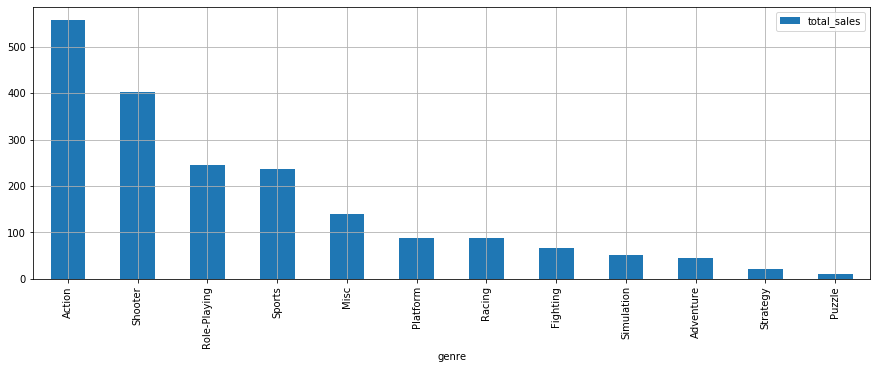

In [123]:
#  суммарные продажи в зависимости от жанра
actual_games_pivot_genre = (actual_data_games
                            .pivot_table(index='genre',
                                       values='total_sales', 
                                       aggfunc='sum'
                                      )
                            .sort_values(by='total_sales',
                                       ascending=False
                                      )
                            )

actual_games_pivot_genre.plot(grid=True,
                                  kind='bar',
                                  figsize=(15, 5)
                                 )

###  Вывод:

Данные по годам за все время не показательны. Продажи в 2015 и 2016 годах меньше чем в 2008.

Проверив ТОП 5 платформ по сумме продаж в разбивке по годам наблюдается рост популярности платформы в первые 5-6 лет и затем спад. Срок жизни платформы в среднем 10 лет.

Дла анализа определилил актуальный период: 6 лет с 2011 г.

Наибольшие продажи наблюдаютя на платформе PS3 (445,57 млн. долл), далее идет X360 (380,43 млн. долл), затем PS4 (314,14 млн. долл).

На основание полученной таблицы и построив гистограммы по платформам можно сделать выводы, что за последние 6 лет наблюдается спад продаж на платформах PS3 X360 PC, то есть можно сделдать вывод, что пик популярности этих платформ прошёл.

Судя по данным наиболее перспективными платформами являются PS4 XOne продажи этих платформ растут, то есть у них есть перспектива развития.

Построив "ящик с усами" и гистограмму с по среднем продажам, можно выделить наиболее популярные платформы: PS4, X360, XOne и PS4.

Наибольшая корреляция продаж с оценками критиков 0,3

---

### Шаг 4. Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
    - Самые популярные платформы (топ-5). Опишите различия в долях продаж.
    - Самые популярные жанры (топ-5). Поясните разницу.
    - Влияет ли рейтинг ESRB на продажи в отдельном регионе?

#### Самые популярные платформы (топ-5).

In [124]:
#группировка данных по платформе в зависимости от региона
actual_games_pivot_na = (actual_data_games
                            .pivot_table(index='platform',
                                       values='na_sales', 
                                       aggfunc='sum'
                                      )
                            .sort_values(by='na_sales',
                                       ascending=False
                                      )
                            )

actual_games_pivot_na.columns = ['sales']
actual_games_pivot_na['share_%'] = round(actual_games_pivot_na ['sales']/actual_games_pivot_na ['sales'].sum()*100,2)
actual_games_pivot_na.head()

,sales,share_%
platform,,
X360,226.80,27.33
PS3,168.26,20.28
PS4,108.74,13.10
XOne,93.12,11.22
3DS,82.65,9.96


In [125]:
#группировка данных по платформе в зависимости от региона
actual_games_pivot_eu = (actual_data_games
                            .pivot_table(index='platform',
                                       values='eu_sales', 
                                       aggfunc='sum'
                                      )
                            .sort_values(by='eu_sales',
                                       ascending=False
                                      )
                            )

actual_games_pivot_eu.columns = ['sales']
actual_games_pivot_eu['share_%'] = round(actual_games_pivot_eu ['sales']/actual_games_pivot_eu ['sales'].sum()*100,2)
actual_games_pivot_eu.head()

,sales,share_%
platform,,
PS3,163.10,24.34
PS4,141.09,21.06
X360,117.14,17.48
3DS,61.27,9.14
PC,56.95,8.50


In [126]:
#группировка данных по платформе в зависимости от региона
actual_games_pivot_jp = (actual_data_games
                            .pivot_table(index='platform',
                                       values='jp_sales', 
                                       aggfunc='sum'
                                      )
                            .sort_values(by='jp_sales',
                                       ascending=False
                                      )
                            )

actual_games_pivot_jp.columns = ['sales']
actual_games_pivot_jp['share_%'] = round(actual_games_pivot_jp ['sales']/actual_games_pivot_jp ['sales'].sum()*100,2)
actual_games_pivot_jp.head()

,sales,share_%
platform,,
3DS,100.62,40.96
PS3,49.39,20.11
PSP,24.04,9.79
PSV,21.84,8.89
PS4,15.96,6.50


По продажам в Северной Америке:
Наибольшие продажи в разбивке по платформам: X360, доля продаж 27,33% от общего объема в регионе. далее идут PS3-20,28% и PS4-13,10%.

По продажам в Европе:
Наибольшие продажи в разбивке по платформам: PS3, доля продаж 24,34% от общего объема в регионе. Далее идут PS4-21,06% и X360-17,48%.

По продажам в Японии:
Наибольшие продажи в разбивке по платформам: 3DS, доля продаж 40,96% от общего объема в регионе. Далее идут PS3 - 20,11% и PSP-9.79%.

#### Самые популярные жанры (топ-5). 

In [127]:
# #группировка данных по жанрам  в зависимости от региона
actual_games_genre_na = (actual_data_games
                            .pivot_table(index='genre',
                                       values='na_sales', 
                                       aggfunc='sum'
                                      )
                            .sort_values(by='na_sales',
                                       ascending=False
                                      )
                            )
actual_games_genre_na.head()

,na_sales
genre,
Action,230.98
Shooter,194.43
Sports,108.70
Role-Playing,83.78
Misc,69.69


In [128]:
# #группировка данных по жанрам  в зависимости от региона
actual_games_genre_eu = (actual_data_games
                            .pivot_table(index='genre',
                                       values='eu_sales', 
                                       aggfunc='sum'
                                      )
                            .sort_values(by='eu_sales',
                                       ascending=False
                                      )
                            )
actual_games_genre_eu.head()

,eu_sales
genre,
Action,199.37
Shooter,148.02
Sports,88.48
Role-Playing,62.30
Racing,40.62


In [129]:
# #группировка данных по жанрам  в зависимости от региона
actual_games_genre_jp = (actual_data_games
                            .pivot_table(index='genre',
                                       values='jp_sales', 
                                       aggfunc='sum'
                                      )
                            .sort_values(by='jp_sales',
                                       ascending=False
                                      )
                            )
actual_games_genre_jp.head()

,jp_sales
genre,
Role-Playing,79.87
Action,63.62
Misc,17.60
Fighting,12.38
Platform,12.13


#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [130]:
# группировка по рейтингу в зависмости от региона
actual_games_esbr_na = (actual_data_games
                            .pivot_table(index='rating',
                                       values='na_sales', 
                                       aggfunc='sum'
                                      )
                            .sort_values(by='na_sales',
                                       ascending=False
                                      )
                            )
actual_games_esbr_na.head()

,na_sales
rating,
M,360.28
E,206.24
T,145.16
E10+,117.72
EC,0.42


In [131]:
actual_games_esbr_ea = (actual_data_games
                            .pivot_table(index='rating',
                                       values='eu_sales', 
                                       aggfunc='sum'
                                      )
                            .sort_values(by='eu_sales',
                                       ascending=False
                                      )
                            )
actual_games_esbr_ea.head()

,eu_sales
rating,
M,294.81
E,190.45
T,106.79
E10+,78.00
RP,0.03


In [132]:
actual_games_esbr_jp = (actual_data_games
                            .pivot_table(index='rating',
                                       values='jp_sales', 
                                       aggfunc='sum'
                                      )
                            .sort_values(by='jp_sales',
                                       ascending=False
                                      )
                            )
actual_games_esbr_jp.head()

,jp_sales
rating,
T,100.08
M,72.07
E,62.27
E10+,11.23
EC,0.00


### По продажам в Северной Америке:
Наибольшие продажи в разбивке по платформам: X360, доля продаж 27,33% от общего объема в регионе. далее идут PS3-20,28% и PS4-13,10%.

#### Продажи в разбивке по жанрам:
- Action- 230,98
- Shooter - 194,43
- Sports - 108,7

#### Прожажи в зависимоти от рейтинга:
- М - 360
- Е - 206
- Т - 145

### По продажам в Европе:
Наибольшие продажи в разбивке по платформам: PS3, доля продаж 24,34% от общего объема в регионе. Далее идут PS4-21,06% и X360-17,48%.


#### Продажи в разбивке по жанрам:
- Action- 199,37
- Shooter - 148,02
- Sports - 88,48

#### Прожажи в зависимоти от рейтинга:
- М - 294
- Е - 190
- Т - 106


### По продажам в Японии:
Наибольшие продажи в разбивке по платформам: 3DS, доля продаж 40,96% от общего объема в регионе. Далее идут PS3 - 20,11% и PSP-9.79%.

#### Продажи в разбивке по жанрам:
- Role-Playing - 79,87
- Action	- 63,62
- Misc - 17,6

#### Прожажи в зависимоти от рейтинга:
- Т - 100
- М - 72
- Е - 62

Разница в данных может наблюдаться в связи с культыными особонностями в регионах. Так наример, Япония значительно отличается от других стран. 

### Шаг 5. Проверьте гипотезы

#### 5.1 Гипотеза о равенстве рейтингов по платформам

Проверим гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковы. Для этого сределаем 2 среда по платформам.

- Н0: средний рейтинг пользователей Xbox One и PC одинаковые
- Н1: отличаются

In [137]:
# сделаем сред и запишем его в переменные
xone_data = actual_data_games.query('platform == "XOne"')
pc_data = actual_data_games.query('platform == "PC"')

# Проверка гипотезы средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
alpha = .01

results = st.ttest_ind(
    xone_data['user_score'], 
    pc_data['user_score'],
    nan_policy='omit'
)

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.6601000395359753
Не получилось отвергнуть нулевую гипотезу


В ходе проверки гипотезы о равенве рейтингов по платформам выяснилось, что разницы в оценке пользователей по платформам Xbox One и PC нет.

#### 5.2 Гипотеза о равенстве рейтингов по жанрам

Проверим гипотезу, что cредние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные. Для этого сределаем 2 среда по платформам.

- Н0: cредние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые
- Н1: разные

In [138]:
# сделаем сред и запишем его в переменные
action_data = actual_data_games.query('genre == "Action"')
sports_data = actual_data_games.query('genre == "Sports"')

# Проверка гипотезы средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
alpha = .05

results = st.ttest_ind(
    action_data['user_score'], 
    sports_data['user_score'],
    nan_policy='omit' 
)

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.147206374857127e-24
Отвергаем нулевую гипотезу


В ходе проверки гипотезы о равенстве рейтингов по жанрам выяснилось, что существует значительная разница в оценках пользователей.

### Шаг 6. Общий вывод

По продажам в Северной Америке: Наибольшие продажи в разбивке по платформам: X360, доля продаж 27,33% от общего объема в регионе. далее идут PS3-20,28% и PS4-13,10%.

По продажам в Европе: Наибольшие продажи в разбивке по платформам: PS3, доля продаж 24,34% от общего объема в регионе. Далее идут PS4-21,06% и X360-17,48%.

По продажам в Японии: Наибольшие продажи в разбивке по платформам: 3DS, доля продаж 40,96% от общего объема в регионе. Далее идут PS3 - 20,11% и PSP-9.79%.

### По продажам в Северной Америке:
Наибольшие продажи в разбивке по платформам: X360, доля продаж 27,33% от общего объема в регионе. далее идут PS3-20,28% и PS4-13,10%.

#### Продажи в разбивке по жанрам:
- Action- 230,98
- Shooter - 194,43
- Sports - 108,7

#### Прожажи в зависимоти от рейтинга:
- М - 360
- Е - 206
- Т - 145

### По продажам в Европе:
Наибольшие продажи в разбивке по платформам: PS3, доля продаж 24,34% от общего объема в регионе. Далее идут PS4-21,06% и X360-17,48%.

#### Продажи в разбивке по жанрам:
- Action- 199,37
- Shooter - 148,02
- Sports - 88,48

#### Прожажи в зависимоти от рейтинга:
- М - 294
- Е - 190
- Т - 106

### По продажам в Японии:
Наибольшие продажи в разбивке по платформам: 3DS, доля продаж 40,96% от общего объема в регионе. Далее идут PS3 - 20,11% и PSP-9.79%.

#### Продажи в разбивке по жанрам:
- Role-Playing - 79,87
- Action	- 63,62
- Misc - 17,6

#### Прожажи в зависимоти от рейтинга:
- Т - 100
- М - 72
- Е - 62

Разница в данных может наблюдаться в связи с культыными особонностями в регионах. Так наример, Япония значительно отличается от других стран. 

### Проверка гипотез
#### Гипотеза о равенстве рейтингов по платформам
В ходе проверки гипотезы о равенве рейтингов по платформам выяснилось, что разницы в оценке пользователей по платформам Xbox One и PC нет.

####  Гипотеза о равенстве рейтингов по жанрам
В ходе проверки гипотезы о равенстве рейтингов по жанрам выяснилось, что существует значительная разница в оценках пользователей.



Иp проведенного анализа можно сделать вывод, что при планирование маркетинговой акции стоит учитывать Рейтинги игр, жанр и регион. Особое внимание стоит уделить азиатскому 

### Чек-лист готовности проекта

- [x] открыт файл
- [x] файлы изучены (выведены первые строки, метод info())
- [x] Замените названия столбцов (приведите к нижнему регистру);
- [x] Преобразуйте данные в нужные типы. 
- [x] Обработайте пропуски при необходимости:
- [x] Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.
- [x] Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- [x] Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- [x] Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
- [x] Не учитывайте в работе данные за предыдущие годы.
- [x] Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
- [x] Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.
- [x] Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
- [x] Соотнесите выводы с продажами игр на других платформах.
- [x] Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?
- [x] Определите для пользователя каждого региона (NA, EU, JP):
    - Самые популярные платформы (топ-5). Опишите различия в долях продаж.
    - Самые популярные жанры (топ-5). Поясните разницу.
    - Влияет ли рейтинг ESRB на продажи в отдельном регионе?
- [x] Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- [x] Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.
- [x] общие выводы